## Comparing Groups

Below are some examples of common parametric tests for comparing groups and their non-parametric equivalents, along with their respective function names in the Python package SciPy.  We won't try them all out right now.

### Parametric vs Non-Parametric

Note that a 'parametric' test is a test that uses some known set of parameter estimates (mean and standard deviation, for example) to represent the information in the data.  When a variable has a mathematically-understood distribution (Gaussian/Normal, Binomial, Poisson, etc), it can be accurately summarized using a few parameters, so a parametric test makes sense.  For variables that don't conform to a distribution type, their information can't be summarized in just a few parameters, and representing them with these types of parameters will be misleading (like taking the mean of a very skewed distribution). For these, non-parametric tests are used. These tests rely on other estimates that represent certain pieces of information within a variable (like the median, which describes the middlemost datapoint when a variable is sorted by size) but not the whole variable.  Because the estimates they use contain less information than parametric estimates, non-parametric tests are less able to detect very small effects than parametric tests, but they are also less vulnerable to bias from extreme observations in the data.

<table border="1">
<tr>
<th>Experiment Type</th>
<th colspan="2">Normally Distributed</th>
<th colspan="2">Non-Normally Distributed</th>
</tr>
<tr>
<th></th>
<th>Test</th>
<th>Function</th>
<th>Test</th>
<th>Function</th>
</tr>
<tr>
<td>A/B test, two independent groups</td>
<td>t-test for independent samples</td>
<td>[`scipy.stats.ttest_ind`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)</td>
<td>Mann-Whitney U test<br>
Mood's Median Test<br>
Kruskal-Wallis Test</td>
<td>[`scipy.stats.mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)<br>
[`scipy.stats.median_test`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html#scipy.stats.median_test)<br>
[`scipy.stats.kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal)</td>
</tr>
<tr>
<td>A/B/C/… test, three or more independent groups</td>
<td>One-way ANOVA</td>
<td>[`scipy.stats.f_oneway`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway)</td>
<td>Mood’s median test<br>
Kruskal-Wallis test</td>
<td>[`scipy.stats.median_test`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html#scipy.stats.median_test)<br>
[`scipy.stats.kruskal`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal)</td>
</tr>
<tr>
<td>A/B test where all participants experience both versions</td>
<td>t-test for paired samples</td>
<td>[`scipy.stats.ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel)</td>
<td>Wilcoxon signed-rank test</td>
<td>[`scipy.stats.wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon)</td>
</tr>
</table>


You can read more about these and other functions in the [SciPy stats documentation](https://docs.scipy.org/doc/scipy/reference/stats.html).

The prototypical A/B test generates data from two groups.  The goal of the analysis is to compare the distributions to determine if there is a meaningful difference.  Typically this is done by computing some measure of central tendency and some measure of variance for each group, and then comparing the size of the difference of the central tendencies to a threshold chosen based on the amount of variance in the groups and the size of the groups. 

### Parametric tests

If visual inspection assures you that your data resembles one of the many distributions with known mathematical properties, then you would use a parametric test to compare differences between groups.  Here we will focus on parametric tests that assume a normal distribution.

Whether comparing two groups or more than two, the logic behind parametric tests comparing groups is the same: Calculate how much information in the data can be explained by belonging to groups (often by computing the difference between group means).  Then calculate how much information is in the data overall (often by calculating the standard deviation). Finally, divide the variance explained in the means by the total variance to get a test statistic representing the information explained by group membership in the context of the overall variance.  

The test statistic, in combination with the sample size, is then used to estimate how likely that difference is to have occurred if the groups did not differ in the population.  The smaller the likelihood, the more confident we can be that the difference we observe is real and not due to natural variability in the population.  Typically, a likelihood smaller than 5% is used as a threshold for concluding that the groups are not the same in the population.

For example, let's compare the height of wooden, steel, and plastic rollercoasters.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

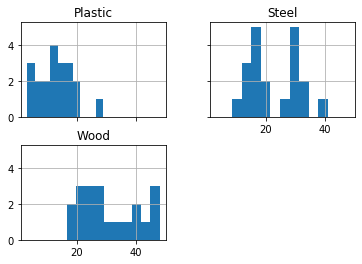

In [2]:
# First, create and load some coaster height data.

coaster_heights = pd.DataFrame()

steel_heights = [
    18.5, 14, 30.2, 25.2024, 15, 16, 13.5, 30, 20, 17, 13.716, 8.5, 16.1, 18,
    41, 30.3, 32.004, 28.004, 30.48, 34
    ]

wood_heights = [
    38.70, 46, 27.8, 43.52, 33.77, 29.26, 16.764, 45, 48.1, 16.764, 24.384,
    24.5, 40, 35.96, 22.24, 21.33, 27.73, 23.46, 21.64, 30.12
    ]

plastic_heights = [
    9, 8.2, 12, 21, 6.3, 11.7, 19.44, 4.75, 13, 18, 15.5, 15.6, 10, 11.77, 29,
    5, 3.2, 14.75, 18.2, 17.7
    ]

coaster_heights['Steel'] = steel_heights
coaster_heights['Wood'] = wood_heights
coaster_heights['Plastic'] = plastic_heights

# Visualize our data.
coaster_heights.hist(sharey=True,sharex=True)
plt.show()

While none of the three distributions are very pretty, it still seems as though they are sufficiently close to the normal distribution (given the small sample size) that the mean and standard deviation would give us useful information.  We are comparing three unrelated groups of data, so the appropriate parametric choice is a one-way Analysis of Variance (ANOVA).  

## One-Way ANOVA

Note that the test statistic will identify whether any of the groups differs from the others.  The F-test alone cannot say which group (or groups) are the different ones.

\begin{equation}
F=\frac{{n\sum(\bar{Y}_j-\bar{Y})^2}/{(a-1)}}{{\sum\sum(Y_{ij}-\bar{Y}_j)^2}/{(N-a)}}
\end{equation}

*n* is the number of datapoints in each group.  
$\bar{Y}_j$ is the mean for the *j*th group.  
$\bar{Y}$ is the overall mean.  
$Y_{ij}$ is the *i*th value of *j*th group.  
*a* is the number of groups.  
*N* is the total number of datapoints.  

The logic of the one-way ANOVA is to compare how much the group means $\bar{Y}_j$ differ from the overall mean $\bar{Y}$ to how much the observations within each group $Y_{ij}$ differ from the mean of that group $\bar{Y}_j$.  The ratio of the average group difference to average within-group variance is then used, in combination with the sample size *N*, to calculate the probability of getting a difference that large in the sample if there were no meaningful difference between the groups in the population.

Steel      22.57532
Wood       30.85210
Plastic    13.20550
dtype: float64


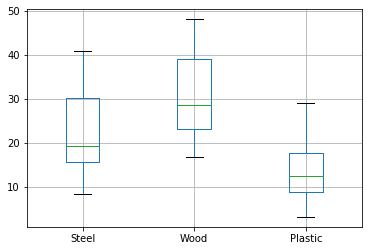

21.515815855142634
1.0927449918229045e-07


In [3]:
# Printing the means for each group.
print(coaster_heights.mean())

coaster_heights.boxplot()
plt.show()


F, p = stats.f_oneway(
    coaster_heights['Steel'],
    coaster_heights['Wood'],
    coaster_heights['Plastic'])

# The F statistic.
print(F)

# The probability. A p < .05 would lead us to believe the group means were
# not all similar in the population.
print(p)

It appears that the three groups (Steel, Wood, and Plastic) are likely to differ in the population (p < .0001).  But which group is the odd one out?  Returning to the histograms above, visual inspection suggests that the roller coasters made of plastic are shorter than the ones made of steel and wood.  To test whether plastic is the odd one out, we can perform a set of pairwise t-tests comparing each group to each other group.  

In [4]:
print(stats.ttest_ind(coaster_heights['Steel'], coaster_heights['Wood']))
print(stats.ttest_ind(coaster_heights['Steel'], coaster_heights['Plastic']))
print(stats.ttest_ind(coaster_heights['Plastic'], coaster_heights['Wood']))

Ttest_indResult(statistic=-2.785911485728798, pvalue=0.008281657085474181)
Ttest_indResult(statistic=3.8446067874474887, pvalue=0.00044650642104150624)
Ttest_indResult(statistic=-6.683437837231596, pvalue=6.614422528990009e-08)


The results of this test are interesting!  Contrary to what we might have expected from a visual inspection of the histograms, the means of all three groups seem to be significantly different from one another.  Wood is highest, then Steel, then Plastic.  

## Tests for Dependent Groups

So far, we have assumed that the groups we are comparing are made up of different people.  Sometimes, however, we want to compare people to themselves, to see if changing an element (the color of a website, the text of an email, etc) changes peoples' reactions.  This type of data leads to dependent groups, because if we know a person's response to condition A, we already have some information about how they might respond to condition B.  As a result, different statistical methods are needed if we want to compare condition A to condition B.

A paired t-test is used to compare two dependent (or "paired") groups.  It differs from an independent t-test in two ways:
1. The difference score is calculated by subtracting each pair of scores and then calculating the mean difference, rather than calculating the difference of the means.  
    - If there is no missing data, the two methods are identical.  However, in a paired t-test if a person is missing data in condition A, their data in condition B is discarded.
2. The error term is calculalted as the standard deviation of the difference scores.


## Thinking Like a Data Scientist
Why use dependent groups?  Come up with a few scenarios where getting repeated measures from the same people would be beneficial.

1. Dependent groups would be beneficial in pre-post study designs. For example, a company wants to test out new product that aims to improve students’ reading skills.  A dependent t-test would be a way to see if the product was effective. Students can take an assessment to measure their reading level before using the new education product. Then, students will train with the product for a certain period amount of time and retake the assessment. A t-test can be preformed on the before and after assessments to see if there is significant difference between the results.  

2. Dependent t-tests can also be use to introduce a control group. For instance, if you wanted to investigate whether a dieting program was effective in weight loss, you can compare participants’ weights before and after the program using a dependent t-test. To improve the study design, you can introduce a control trial. During this period, participants receive “normal” or no dietary counseling for a certain amount of time. Then, participants receive the new dietary counseling. At the end of each period, assessments can be given and compared. 
